# Wind Farms (Foreshore Process)

<https://data.gov.ie/dataset/wind-farms-foreshore-process>

In [1]:
import glob
import os
from datetime import datetime, timezone
from zipfile import ZipFile

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import pooch
import shapely
from geocube.api.core import make_geocube
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# base data download directory
DATA_DIR = os.path.join("data", "wind-farms-foreshore-process")
os.makedirs(DATA_DIR, exist_ok=True)

URL = (
    "https://opendata.arcgis.com/api/v3/datasets/"
    "803a4ecc22aa4cc09111072a0bbc4fac_2/downloads/"
    "data?format=shp&spatialRefId=4326&where=1%3D1"
)
KNOWN_HASH = None
FILE_NAME = "wind-farms-foreshore-process.zip"

DATA_FILE = os.path.join(DATA_DIR, FILE_NAME)

# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

In [3]:
# download data if necessary
if not os.path.isfile(DATA_FILE):
    pooch.retrieve(
        url=URL,
        known_hash=KNOWN_HASH,
        fname=FILE_NAME,
        path=DATA_DIR
    )

    with open(f"{DATA_FILE[:-4]}.txt", "w", encoding="utf-8") as outfile:
        outfile.write(
            f"Data downloaded on: {datetime.now(tz=timezone.utc)}\n"
            f"Download URL: {URL}"
        )

SHA256 hash of downloaded file: eb0f0c1b14a0db959b47795a623d0e8b74bfb32285656905ae30136a4e34446b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [3]:
with open(f"{DATA_FILE[:-4]}.txt") as f:
    print(f.read())

Data downloaded on: 2023-09-11 14:08:54.610561+00:00
Download URL: https://opendata.arcgis.com/api/v3/datasets/803a4ecc22aa4cc09111072a0bbc4fac_2/downloads/data?format=shp&spatialRefId=4326&where=1%3D1


In [3]:
ZipFile(DATA_FILE).namelist()

['Energy_Offshore_Renewable.shp',
 'Energy_Offshore_Renewable.shx',
 'Energy_Offshore_Renewable.dbf',
 'Energy_Offshore_Renewable.cpg',
 'Energy_Offshore_Renewable.prj',
 'Energy_Offshore_Renewable.xml']

In [3]:
wind_farms = gpd.read_file(
    os.path.join(f"zip://{DATA_FILE}!Energy_Offshore_Renewable.shp")
)

In [4]:
wind_farms.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
wind_farms.shape

(19, 23)

In [6]:
wind_farms.columns

Index(['OBJECTID', 'Name', 'Type', 'MDM_Catego', 'NMPF_Chapt', 'NMPF_Cha_1',
       'Map_Featur', 'Map_Data_S', 'Last_Updat', 'Policy01_N', 'Policy02_N',
       'Policy03_N', 'Owning_Org', 'Metadata_L', 'Policy01_P', 'Policy01_C',
       'Policy02_P', 'Policy02_C', 'Policy03_P', 'Policy03_C', 'Shape__Are',
       'Shape__Len', 'geometry'],
      dtype='object')

In [7]:
wind_farms[["Name", "Type", "MDM_Catego"]]

,Name,Type,MDM_Catego
0,Arklow Bank Phase 2,Fixed-Bottom,Site Investigations
1,Kilmichael Point\r\nKilmichael Point,Fixed-Bottom,Site Investigations
2,Codling Wind Park Extension,Fixed-Bottom,Relevant Projects
3,Codling Wind Park,Fixed-Bottom,Relevant Projects
4,Dublin Array,Fixed-Bottom,Relevant Projects
5,Oriel Wind Farm,Fixed-Bottom,Relevant Projects
6,Clogher Head,Fixed-Bottom,Site Investigations
7,North Irish Sea Array (NISA),Fixed-Bottom,Relevant Projects
8,Sceirde (Skerd) Rocks,Fixed-Bottom,Relevant Projects
9,Arklow Bank Phase I,Fixed-Bottom,Fully Commissioned


In [4]:
# minor name fix
wind_farms.at[1, "Name"] = "Kilmichael Point"

/run/media/nms/Backup/Documents/Git/hydrogen-salt-storage-optimisation/.venv/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


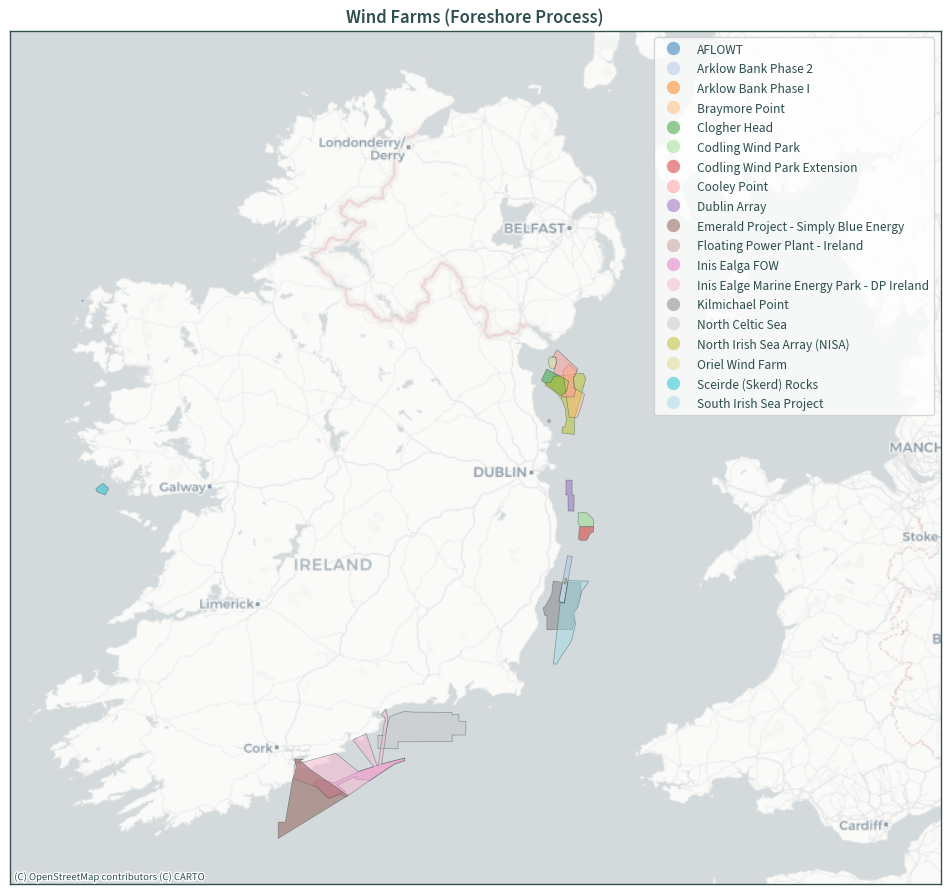

In [9]:
ax = wind_farms.to_crs(3857).plot(
    column="Name", cmap="tab20", alpha=.5, figsize=(10, 10), legend=True,
    legend_kwds={"loc": "upper right"},
    linewidth=.5, edgecolor="darkslategrey"
)
plt.xlim(-1.2e6, -0.3e6)
plt.ylim(6.65e6, 7.475e6)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=7)

plt.title("Wind Farms (Foreshore Process)")

plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

In [5]:
# read Kish Basin data
DATA_DIR = os.path.join("data", "kish-basin")

crs = 23029

def read_dat_file(dat_path: str, dat_crs):
    """
    Read XYZ data layers into an Xarray dataset
    """

    gdf = {}
    for dat_file in glob.glob(os.path.join(dat_path, "*.dat")):
        # read each layer as individual dataframes into a dictionary
        gdf[os.path.split(dat_file)[1][:-4]] = pd.read_fwf(
            dat_file, header=None, names=["X", "Y", "Z"]
        )

        # assign layer name to a column
        gdf[os.path.split(dat_file)[1][:-4]]["data"] = (
            os.path.split(dat_file)[1][:-4]
        )

    # find data resolution
    gdf_xr = (
        gdf[os.path.split(dat_file)[1][:-4]].set_index(["X", "Y"]).to_xarray()
    )
    resx = gdf_xr["X"][1] - gdf_xr["X"][0]
    resy = gdf_xr["Y"][1] - gdf_xr["Y"][0]

    # combine dataframes
    gdf = pd.concat(gdf.values())

    # convert dataframe to geodataframe
    gdf["wkt"] = (
        "POINT (" + gdf["X"].astype(str) + " " + gdf["Y"].astype(str) + ")"
    )
    gdf = gpd.GeoDataFrame(
        gdf, geometry=gpd.GeoSeries.from_wkt(gdf["wkt"]), crs=dat_crs
    )
    gdf.drop(columns=["wkt", "X", "Y"], inplace=True)

    # convert to Xarray dataset
    ds = make_geocube(
        vector_data=gdf,
        resolution=(-abs(resy), abs(resx)),
        align=(abs(resy / 2), abs(resx / 2)),
        group_by="data"
    )

    # create extent polygon
    extent = pd.read_csv(
        os.path.join(DATA_DIR, "Kish GIS Map Extent - Square.csv"), skiprows=2
    )
    extent = gpd.GeoSeries(
        shapely.geometry.Polygon([
            (extent[" X"][0], extent[" Y"][0]),
            (extent[" X"][1], extent[" Y"][1]),
            (extent[" X"][2], extent[" Y"][2]),
            (extent[" X"][3], extent[" Y"][3])
        ]),
        crs=crs
    )

    return ds, extent

In [6]:
ds, extent = read_dat_file(DATA_DIR, dat_crs=crs)

In [7]:
# use extent bounds
xmin, ymin, xmax, ymax = extent.total_bounds

In [8]:
# wind farms intersecting with the extent
wind_farms_ = wind_farms.sjoin(
    gpd.GeoDataFrame(geometry=extent).to_crs(wind_farms.crs)
)

/run/media/nms/Backup/Documents/Git/hydrogen-salt-storage-optimisation/.venv/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


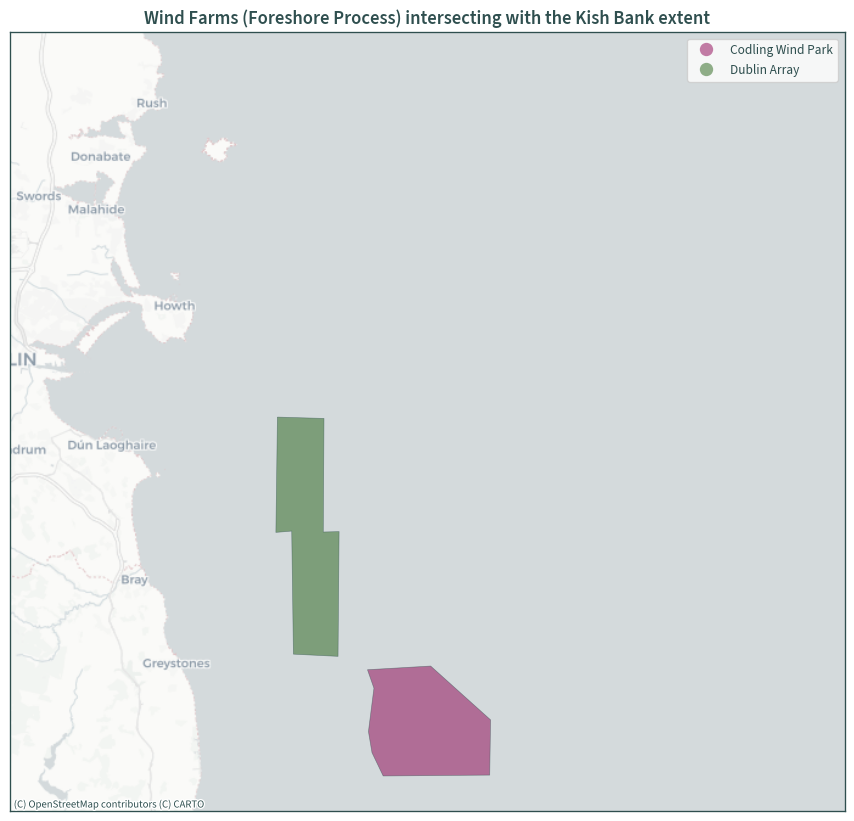

In [9]:
ax = wind_farms_.to_crs(3857).plot(
    column="Name", alpha=.5, figsize=(9, 9), cmap="PiYG",
    linewidth=.5, edgecolor="darkslategrey", legend=True
)
extent.to_crs(3857).boundary.plot(ax=ax, alpha=0)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=10)

plt.title(
    "Wind Farms (Foreshore Process) intersecting with the Kish Bank extent"
)

plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

In [10]:
# wind farms entirely within the extent
wind_farms_ = wind_farms.sjoin(
    gpd.GeoDataFrame(geometry=extent).to_crs(wind_farms.crs),
    predicate="within"
)

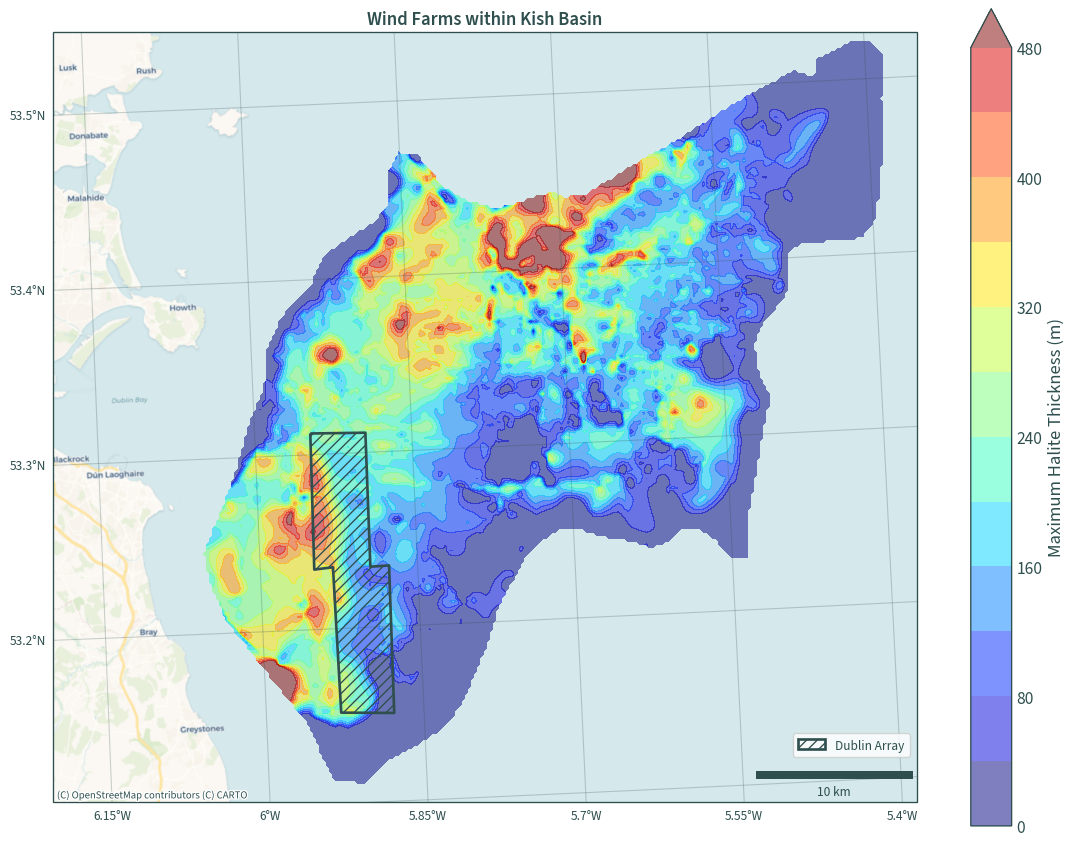

In [14]:
plt.figure(figsize=(12, 9))
ax = plt.axes(projection=ccrs.epsg(crs))

ds.sel(
    data=[x for x in ds["data"].values if "Thickness XYZ" in x]
).max(dim="data")["Z"].plot.contourf(
    cmap="jet",
    alpha=.5,
    robust=True,
    levels=15,
    xlim=(xmin, xmax),
    ylim=(ymin, ymax),
    cbar_kwargs={"label": "Maximum Halite Thickness (m)"}
)
wind_farms_.to_crs(crs).plot(
    ax=ax, hatch="///", edgecolor="darkslategrey", facecolor="none",
    linewidth=2
)

cx.add_basemap(ax, crs=crs, source=cx.providers.CartoDB.Voyager)
ax.gridlines(
    draw_labels={"bottom": "x", "left": "y"}, alpha=.25, color="darkslategrey"
)
ax.add_artist(ScaleBar(
    1, box_alpha=0, location="lower right", color="darkslategrey"
))
ax.legend(
    handles=[
        mpatches.Patch(
            facecolor="none", hatch="///", edgecolor="darkslategrey",
            linewidth=2, label="Dublin Array"
        )
    ],
    loc="lower right", bbox_to_anchor=(1, 0.05)
)

plt.title("Wind Farms within Kish Basin")
plt.tight_layout()
plt.show()